## Species names for predicitons using pandas

### Settings

In [21]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

### Load the data and split into train, test and validation

In [22]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels one hot size:  (6136, 30)
Number of images:  6136


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


### Get the test set set

In [23]:
[_, _, images_test,_, _, labels_one_hot_test, end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)

print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 
    
nim_test = len(labels_one_hot_test)
print('Number of test images: ', nim_test)

Image size - test set:  (614, 64, 64, 3)
Labels size - test set:  (614, 30)
Number of test images:  614


In [24]:
# splitting some of of the info data

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

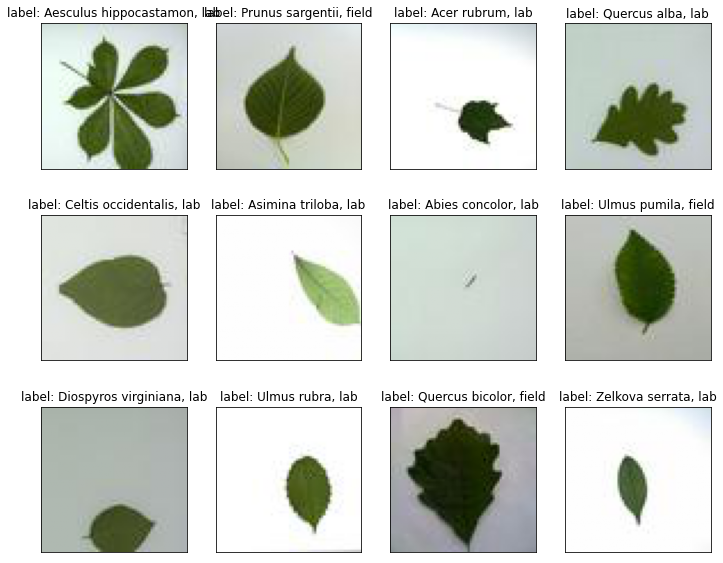

In [25]:
# plot random test images
d.plot_12images(images = images_test, labels = labels_test, sources = sources_test, figsize=(12,10))

### Data formatting

In [26]:
img_rows = 64
img_cols = 64
img_channels = 3

if K.image_data_format() == 'channels_first':
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of testing data: ", np.shape(images_test))

Size of testing data:  (614, 64, 64, 3)


## Model

In [27]:
# path of the Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')

# load the trained model
model = load_model(model_fname) 
print("Loaded model from disk")

model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 12)        912       
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 12)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 24)        7224      
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 24)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 24)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 4056)              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 200)             

Evaluate on test images

In [28]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

Test loss: 0.8515864030157704
Test accuracy: 74.9185667946595 %


## Predicted classes

In [29]:
prediction_numeric = model.predict_classes(images_test)
print("Size of predictions: ", np.shape(prediction_numeric))
predictions= pd.DataFrame({'prediction_numeric': prediction_numeric, 'true_label_numeric': labels_numeric_test, 'true_label': labels_test, 'source': sources_test, 'filename':filenames_test, 'path':path_test})
#order columns
predictions = predictions[['prediction_numeric', 'true_label_numeric', 'true_label', 'source', 'filename', 'path']]
predictions.tail(5)


Size of predictions:  (614,)


,prediction_numeric,true_label_numeric,true_label,source,filename,path
6131,15,15,Tilia americana,lab,pi0057-05-1.jpg,dataset/images/lab/Auto_cropped/tilia_american...
6132,3,3,Betula lenta,lab,wb1194-05-2.jpg,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,25,25,Ptelea trifoliata,lab,pi0005-05-3.jpg,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,22,23,Broussonettia papyrifera,lab,ny1124-02-2.jpg,dataset/images/lab/Auto_cropped/broussonettia_...
6135,4,8,Magnolia grandiflora,field,1249580214_0004.jpg,dataset/images/field/magnolia_grandiflora/1249...


### Add  the species names to the predictions

In [30]:
# correspondence label and label_numeric
info_data_unique = info_data[['label', 'label_numeric']]
info_data_unique = info_data_unique.drop_duplicates(keep='first').sort_values('label_numeric').reset_index(drop=True)
info_data_unique.rename(columns={'label': 'unique_true_label', 'label_numeric':'unique_true_label_numeric'}, 
                        inplace = True)
info_data_unique.head(5)

,unique_true_label,unique_true_label_numeric
0,Acer campestre,0
1,Acer platanoides,1
2,Aesculus hippocastamon,2
3,Betula lenta,3
4,Betula nigra,4


In [31]:
predictions_full = pd.merge(predictions,info_data_unique,left_on='prediction_numeric',
                            right_on='unique_true_label_numeric')
#predictions_full.shape
predictions_full.tail(50)

,prediction_numeric,true_label_numeric,true_label,source,filename,path,unique_true_label,unique_true_label_numeric
564,29,29,Quercus montana,field,13292231172420.jpg,dataset/images/field/quercus_montana/132922311...,Quercus montana,29
565,29,5,Celtis occidentalis,lab,pi0061-04-2.jpg,dataset/images/lab/Auto_cropped/celtis_occiden...,Quercus montana,29
566,29,29,Quercus montana,field,13292231172389.jpg,dataset/images/field/quercus_montana/132922311...,Quercus montana,29
567,29,29,Quercus montana,lab,pi0040-09-2.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
568,29,15,Tilia americana,lab,pi0058-04-4.jpg,dataset/images/lab/Auto_cropped/tilia_american...,Quercus montana,29
569,29,29,Quercus montana,lab,pi0037-01-3.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
570,29,29,Quercus montana,lab,pi1025-06-2.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
571,29,29,Quercus montana,lab,pi0037-07-4.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
572,29,6,Diospyros virginiana,lab,pi0196-08-4.jpg,dataset/images/lab/Auto_cropped/diospyros_virg...,Quercus montana,29
573,29,10,Platanus occidentalis,lab,pi0018-05-4.jpg,dataset/images/lab/Auto_cropped/platanus_occid...,Quercus montana,29


In [32]:
predictions_full.rename(columns={'unique_true_label': 'prediction_label'}, inplace = True)
predictions_full.tail(50)

,prediction_numeric,true_label_numeric,true_label,source,filename,path,prediction_label,unique_true_label_numeric
564,29,29,Quercus montana,field,13292231172420.jpg,dataset/images/field/quercus_montana/132922311...,Quercus montana,29
565,29,5,Celtis occidentalis,lab,pi0061-04-2.jpg,dataset/images/lab/Auto_cropped/celtis_occiden...,Quercus montana,29
566,29,29,Quercus montana,field,13292231172389.jpg,dataset/images/field/quercus_montana/132922311...,Quercus montana,29
567,29,29,Quercus montana,lab,pi0040-09-2.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
568,29,15,Tilia americana,lab,pi0058-04-4.jpg,dataset/images/lab/Auto_cropped/tilia_american...,Quercus montana,29
569,29,29,Quercus montana,lab,pi0037-01-3.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
570,29,29,Quercus montana,lab,pi1025-06-2.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
571,29,29,Quercus montana,lab,pi0037-07-4.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana,29
572,29,6,Diospyros virginiana,lab,pi0196-08-4.jpg,dataset/images/lab/Auto_cropped/diospyros_virg...,Quercus montana,29
573,29,10,Platanus occidentalis,lab,pi0018-05-4.jpg,dataset/images/lab/Auto_cropped/platanus_occid...,Quercus montana,29


In [33]:
predictions_full.drop('unique_true_label_numeric', axis=1, inplace=True)
predictions_full.tail(50)

,prediction_numeric,true_label_numeric,true_label,source,filename,path,prediction_label
564,29,29,Quercus montana,field,13292231172420.jpg,dataset/images/field/quercus_montana/132922311...,Quercus montana
565,29,5,Celtis occidentalis,lab,pi0061-04-2.jpg,dataset/images/lab/Auto_cropped/celtis_occiden...,Quercus montana
566,29,29,Quercus montana,field,13292231172389.jpg,dataset/images/field/quercus_montana/132922311...,Quercus montana
567,29,29,Quercus montana,lab,pi0040-09-2.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana
568,29,15,Tilia americana,lab,pi0058-04-4.jpg,dataset/images/lab/Auto_cropped/tilia_american...,Quercus montana
569,29,29,Quercus montana,lab,pi0037-01-3.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana
570,29,29,Quercus montana,lab,pi1025-06-2.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana
571,29,29,Quercus montana,lab,pi0037-07-4.jpg,dataset/images/lab/Auto_cropped/quercus_montan...,Quercus montana
572,29,6,Diospyros virginiana,lab,pi0196-08-4.jpg,dataset/images/lab/Auto_cropped/diospyros_virg...,Quercus montana
573,29,10,Platanus occidentalis,lab,pi0018-05-4.jpg,dataset/images/lab/Auto_cropped/platanus_occid...,Quercus montana
